This code is meant to help you get started with your project and it adapted from examples contained here: https://github.com/esdalmaijer/PyGaze/tree/master/examples. Please note that this code requires the eye tracker, so do not try to run the code yet unless you want to comment out the tracker lines and play with the display. 

!pip install keyboard
#!pip install PyLink
#!pip install pylink==0.3.2
#!pip install -r requirements.txt
#!pip install --index-url=https://pypi.sr-support.com sr-research-pylink

In [1]:
#import os
#path = 'C:\\Users\\Chloe\\Documents'
#os.chdir(path)

# Import Packages

In [2]:
%%time

# import packages
import os
import random
import time
from collections import defaultdict
import keyboard
import pylink

from pygaze.libscreen import Display, Screen
from pygaze.libinput import Keyboard
from pygaze.eyetracker import EyeTracker
from pygaze.liblog import Logfile
import pygaze.libtime as timer
from pygaze.mouse import Mouse

import numpy as np
import pandas as pd

# Self-built package
from pygazeplot.gazeplotter import *
from pygazeplot.preprocess import *
from pygazeplot.constants import *

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

Wall time: 5.02 s


# Set Up Directories

In [3]:
# Determine where to store and retrieve data files
DIR = os.path.dirname('C:\\Users\\Chloe\\Documents\\Capstone\\')

# the TESTDIR is the path to the directory where test images and data would be stored
TESTDIR = os.path.join(DIR, 'Table_extraction')
# the IMGDIR is the path to the directory that contains the image files
IMGDIR = os.path.join(TESTDIR, 'dataset\\test_img')
# the IMGDIR is the path to the directory that contains the image files
RESULTDIR = os.path.join(TESTDIR, 'runs\\gaze_only')

# read all image names
images = [f for f in os.listdir(IMGDIR) if f.endswith('.png')]
print(images)

['img22.png', 'img29.png', 'img37.png', 'img82.png']


In [4]:
# make new directories for data and plots
def new_dir(parent, new):
    path = os.path.join(parent, new)
    if not os.path.exists(path):
        os.mkdir(path)
    return path


tstamp = time.strftime("%y%m%d-%H%M%S", time.localtime())

PREDDIR = new_dir(RESULTDIR, tstamp)
PLOTDIR = new_dir(PREDDIR, 'plots')
DATADIR = new_dir(PREDDIR, 'gaze_data')

# Experiment variables

In [5]:
# Name of participant
USER_NAME = 'Chloe'

# 1. Device positioning
#    The angle between device and eyes (e.g. lower, upper, lowerleft)
ANGLE = 'lower'                
#    The distance between the participant and the display (cm)
SCREENDIST = 60.0             


# 2. Noise (distractions on page, quick blinks, eyes out of screen, etc.)
#    The noisy situations in experiment (e.g. dstr, qb, eo)
NOISE = ''                    


# 3. Display time: time of image displayed on the screen
#    Maximum length of time for each image to be displayed (ms)
MAXTRIALTIME = 10000         


# 4. Fixation time: time of eyes fixed on AOI
#    Maximum length of time for fixation (s)
# MAXFIXTIME = 5      


# 5. Number of images displayed at each experiment
ntrials = len(images)

# name used for log files, make this something unique (for example dependent on timestamp)
l = [tstamp, 
     USER_NAME, 
     ANGLE, 
     'S'+str(int(SCREENDIST)),
     NOISE, 
     'D'+str(MAXTRIALTIME//1000)]
     #'F'+str(MAXFIXTIME)]

LOGFILENAME = '_'.join([s for s in l if s!='']) 
print(LOGFILENAME)

220417-155411_Chloe_lower_S60_D10


# Table Detection with CV

# Pygaze Display

pygame 2.1.2 (SDL 2.0.18, Python 3.8.3)
Hello from the pygame community. https://www.pygame.org/contribute.html
Initiation time spent: 67.434 s
False
Calibration time spent: 70.682 s
function not supported yet
function not supported yet
function not supported yet
function not supported yet
Experiment time spent: 138.083 s
Disconnection time spent: 0.499 s
Preprocessing time spent: 0.661 s
Prediction time spent: 0.062 s
7.6067 	WARNING 	Monitor specification not found. Creating a temporary one...
7.6123 	WARNING 	User requested fullscreen with size [1024 1024], but screen is actually [1536, 864]. Using actual size
9.9639 	WARNING 	TextStim.alignHoriz is deprecated. Use alignText and anchorHoriz attributes instead
77.2982 	WARNING 	TextStim.alignHoriz is deprecated. Use alignText and anchorHoriz attributes instead
80.8437 	WARNING 	TextStim.alignHoriz is deprecated. Use alignText and anchorHoriz attributes instead
114.4779 	WARNING 	TextStim.alignHoriz is deprecated. Use alignText and an

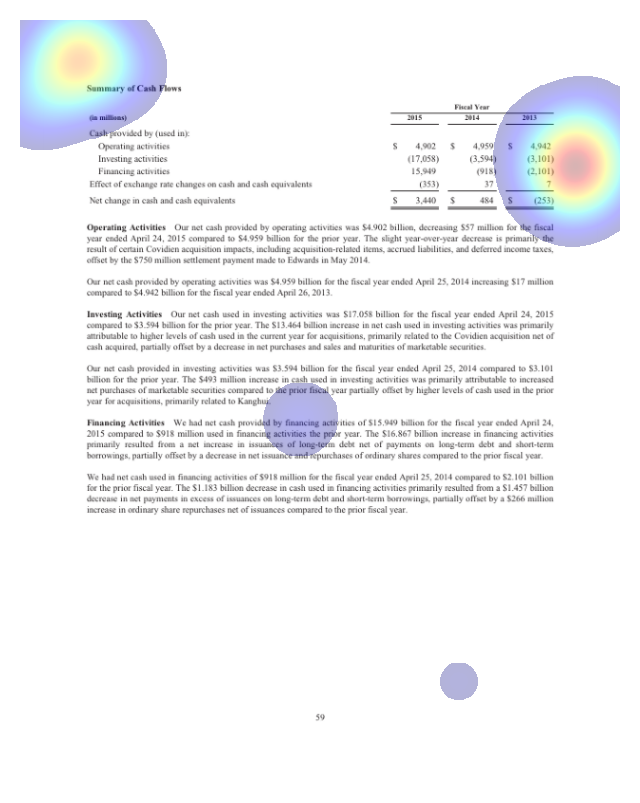

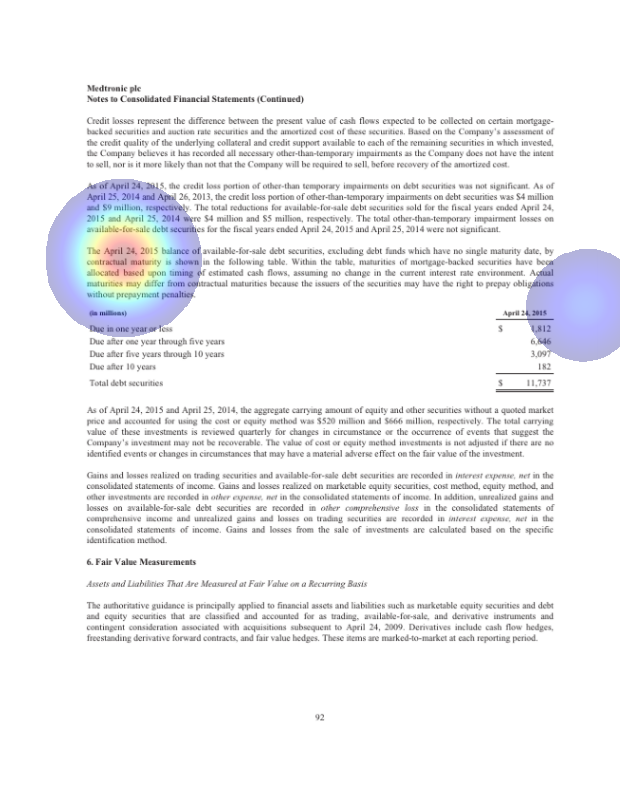

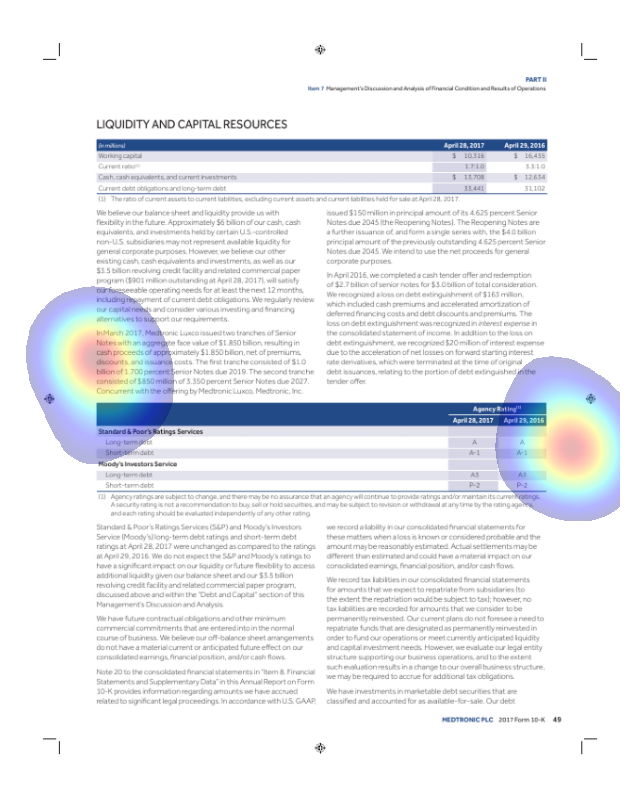

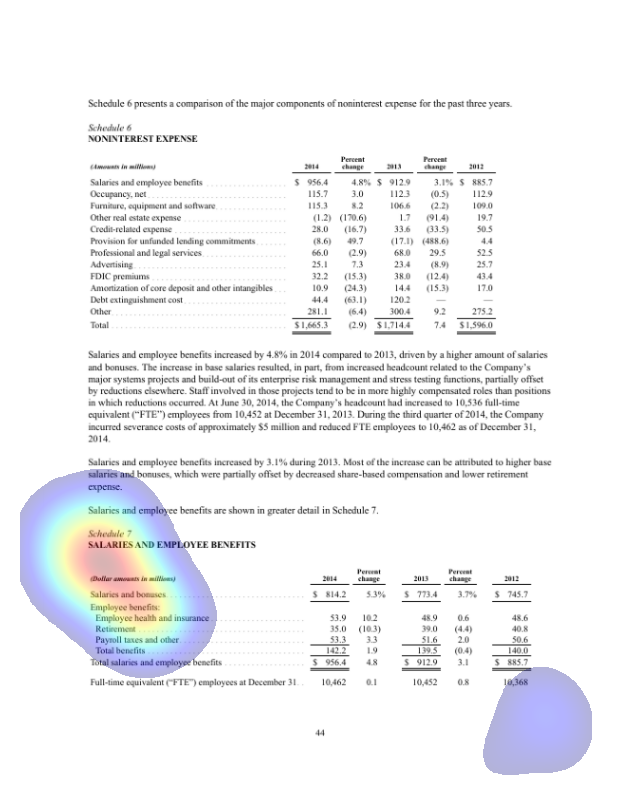

In [6]:
%%time

# path to logfile establishes where the gaze data will be written
LOGFILE = os.path.join(DATADIR, LOGFILENAME)

# initialize objects
disp = Display()
#ip="127.0.0.1"
ip = "172.20.10.3"
scr = Screen()

mouse = Mouse(mousebuttonlist=None, timeout=10000)
mouse.set_visible(visible=True)

# create keyboard object
kb = Keyboard(keylist=['space'], timeout=10000)
init_t0 = time.time()
tracker = EyeTracker(disp, debug=True, logfile=LOGFILE)

# establish data connection to tracker
state=True
acknowledged, timeout = tracker.opengaze._send_message('SET', \
    'ENABLE_SEND_DATA', \
    values=[('STATE', int(state))], \
    wait_for_acknowledgement=True)
init_t1 = time.time()
init_t = round(init_t1-init_t0,3)
print('Initiation time spent: ' + str(init_t) + ' s')
print(acknowledged)

# if you want to log any additional information, you will do it this way (saved to different file than gaze data)
log = Logfile()

# set up experiment and perform calibration

# display instructions
scr.draw_text(text="Please keep still during the experiment. Click the mouse to start the calibration.", fontsize=20)
disp.fill(scr)
disp.show()

# wait for a keypress
#kb.get_key(keylist=None, timeout=None, flush=True)
mouse.get_clicked()


cal_t0 = time.time()
# calibrate the eye tracker
tracker.calibrate()
cal_t1 = time.time()
cal_t = round(cal_t1-cal_t0,3)
print('Calibration time spent: ' + str(cal_t) + ' s')
#log.write(vallist = [cal_t])


screenshot_name = time.strftime("%y%m%d-%H%M%S", time.localtime())+"_calibration.png"
disp.make_screenshot(filename=os.path.join(PREDDIR, screenshot_name))
# perform experiment

scr.clear()
txt = f'You will see {ntrials} images in sequence, each containing one or more tables. '
txt = txt + f'Please gaze at a table of interest in each image for {MAXTRIALTIME//1000} seconds.'
txt = txt + '\n'+ f'Try your best to ONLY focus on the 4 CORNERS of the table.'
txt = txt + '\n\n' + f'Click the mouse to start.'
scr.draw_text(text= txt, fontsize=20)
disp.fill(scr)
disp.show()

# wait for a keypress
#kb.get_key(keylist=None, timeout=None, flush=True)
mouse.get_clicked()

#Generate random numbers between 10 and 30
#randomlist = random.sample(range(0, len(images)), ntrials)

exp_t0 = time.time()
# loop through all trials
for trialnr in range(ntrials):
    
    # gerate random index
    #i = random.randrange(len(images))
    
    # PREPARE TRIAL
    # draw the image
    scr.clear()
    scr.draw_image(os.path.join(IMGDIR,images[trialnr]),scale=RESCALE)
    
    # RUN TRIAL
    # start tracking
    tracker.start_recording()
    tracker.log("TRIALSTART %d" % trialnr)
    tracker.log("IMAGENAME %s" % images[trialnr])
    tracker.status_msg("trial %d/%d" % (trialnr+1, ntrials))
    
    # present image
    disp.fill(scr)
    t0 = disp.show()
    tracker.log("image online at %d" % t0)
    
    start_time = time.time()
    while True:  
        # key is pressed or time exceeds limit
        if keyboard.is_pressed('space'):
            break
        elif (time.time() - start_time) > (MAXTRIALTIME / 1000):  
            break 
    
    timer.pause(FIXATIONTIME)
    
    # reset screen
    disp.fill()
    t1 = disp.show()
    tracker.log("image offline at %d" % t1)

    
    # stop recording
    tracker.log("TRIALEND %d" % trialnr)
    tracker.stop_recording()
    
    # TRIAL AFTERMATH
    # bookkeeping
    #log.write(vallist = [trialnr, images[trialnr], t1-t0])
    
    
    # inter trial interval
    timer.pause(500)
    
# close experiment
# loading message
scr.clear()
exp_t1 = time.time()
exp_t = round(exp_t1-exp_t0,3)
print('Experiment time spent: ' + str(exp_t) + ' s')

scr.draw_text(text="Transferring the data file, please wait...", fontsize=20)
disp.fill(scr)
disp.show()

close_t0 = time.time()
# neatly close connection to the tracker
# (this will close the data file, and copy it to the stimulus PC)
tracker.close()
# close the logfile
log.close()

close_t1 = time.time()
close_t = round(close_t1-close_t0,3)
print('Disconnection time spent: ' + str(close_t) + ' s')


############################## preprocess ##################################

scr.clear()
scr.draw_text(text="Processing data...", fontsize=20)
disp.fill(scr)
disp.show()

prep_t0 = time.time()
for file in os.listdir(DATADIR):
    if not file.startswith(LOGFILENAME):
        continue
    elif file.endswith(".tsv"):
        d = file 
    elif file.endswith(".txt"):
        l = file
#print('d:',d, '\nl:',l)
data = process_data(DATADIR, d, l, ntrials)

data = data[data.IMGID != -1]
filename = os.path.join(DATADIR,'trim_edge_'+time.strftime("%y%m%d-%H%M%S", time.localtime())+'.csv')
trimmed = trim_edge(data=data, dur_thres=0.15, fix_flag=False, filename = filename)

prep_t1 = time.time()
prep_t = round(prep_t1-prep_t0,3)
print('Preprocessing time spent: ' + str(prep_t) + ' s')

#plot heapmap and scanpath
for img in range(len(images)):
    imgname = images[img]
    d = trimmed[trimmed.IMGID == imgname.upper()]

    HPATH = os.path.join(PLOTDIR, imgname.rstrip('.png')+'_heatmap.png')
    SPATH = os.path.join(PLOTDIR, imgname.rstrip('.png')+'_scanpath.png')
    imagefile = os.path.join(IMGDIR,imgname.lower())
    draw_heatmap(d, imagefile=imagefile, durationweight=True, alpha=0.3, savefilename=HPATH)
    #draw_scanpath(d, imagefile=imagefile, alpha=0.3, savefilename=SPATH)

pred_t0 = time.time()
box = dbscan(trimmed,eps=50, min_samples=7)
pred_t1 = time.time()
pred_t = round(pred_t1-pred_t0,3)
print('Prediction time spent: ' + str(pred_t) + ' s')

t = open(os.path.join(PREDDIR, 'clusters.txt'),"w")
t.write(str(list(box.items())))
t.close()

############################### display results #############################
scr.clear()
txt = f'The tables have been saved to the local drive. '+'\n'
txt = txt + f'Click the mouse to see the potential Area of Interest (AOI).'
scr.draw_text(text= txt, fontsize=20)
disp.fill(scr)
disp.show()

# wait for a keypress or a mouseclick
#kb.get_key(keylist=None, timeout=None, flush=True)
mouse.get_clicked()

for trialnr in range(ntrials):
    
    
    # PREPARE TRIAL
    # draw the image
    scr.clear()
    scr.draw_image(os.path.join(IMGDIR,images[trialnr]),scale=1.0)
    disp.fill(scr)
    
    
    img_name = images[trialnr]
    # get bounding box coordinates
    x,y,w,h = box[img_name]
    
    #x,y,w,h = (_x-_w/2)*IMGSIZE[0]+edge_x, (_y-_h/2)*IMGSIZE[1]+edge_y, _w*IMGSIZE[0], _h*IMGSIZE[1]
    scr.draw_rect(colour='blue', x=x, y=y, w=w, h=h, pw=5)
    disp.fill(scr)
    
    #display_str = "{}: {}%".format('Density of fixations', v[i])
    display_str = "Predicted bounding box"
    scr.draw_text(text=display_str, colour='blue', pos=(int(x+w), int(y+h+10)),centre = False, fontsize=20)
    disp.fill(scr)
    
    txt = f'Click the mouse'+'\n'
    txt = txt + f'to show the' + '\n'+ 'next image'
    scr.draw_text(text=txt, pos=(DISPSIZE[0]-5, DISPSIZE[1]//2), centre = False, fontsize=20)
    disp.fill(scr)
    # present image
    disp.fill(scr)
    disp.show()
    SCRSHOT = 'AOI_prediction_'+img_name
    disp.make_screenshot(filename=os.path.join(PLOTDIR, SCRSHOT))
    
    mouse.get_clicked()
    
    # reset screen
    disp.fill()
    disp.show()



# exit message
scr.clear()
scr.draw_text(text="This is the end of this experiment. Thank you for participating!\n\n(click the mouse to exit)", fontsize=20)
disp.fill(scr)
disp.show()

t_list = [init_t, cal_t, exp_t, close_t, prep_t, pred_t]
#t_list

# wait for a keypress
#kb.get_key(keylist=None, timeout=None, flush=True)
mouse.get_clicked()

# close the Display
disp.close()
